<a href="https://colab.research.google.com/github/mastdev/pos_tag/blob/main/HMM_Veterbi_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from collections import defaultdict
import os
import xml.etree.ElementTree as et
import pandas as pd
import math

##Pre Processing


In [9]:
path='/content/drive/MyDrive/Ai_project_hmm/Train-corpus' # replace with the path of your training data

In [10]:
dict_pos=[]
for root_dir,dirs,files in os.walk(path):
    for file in files:
        if file.endswith('.xml'):
            file_path=os.path.join(root_dir,file)
            tree=et.parse(file_path)
            root=tree.getroot()
            for serials in root.findall('.//s'):
                num=serials.attrib.get('n')
                sentence=''
                prev_tag=''
                for words in serials.findall('.//'):
                    if (words.tag=='w' or words.tag=='c') and words.text != None:
                        w=words.text
                        w=w.lower()
                        word=w.replace(' ','')
                        term=words.attrib.get('c5')
                        
                        string=word+'_'+term+' '
                        sentence+=string
                
                #dict_pos stores sentences as a list
                dict_pos.append(sentence)

In [11]:
test_path='/content/drive/MyDrive/Ai_project_hmm/Test-corpus' # replace the path with your test path

In [12]:
test_dict=[]
for root_dir,dirs,files in os.walk(test_path):
    for file in files:
        if file.endswith('.xml'):
            file_path=os.path.join(root_dir,file)
            tree=et.parse(file_path)
            root=tree.getroot()
            for serials in root.findall('.//s'):
                num=serials.attrib.get('n')
                sentence=''
                prev_tag=''
                for words in serials.findall('.//'):
                    if (words.tag=='w' or words.tag=='c') and words.text != None:
                        w=words.text
                        w=w.lower()
                        word=w.replace(' ','')
                        term=words.attrib.get('c5')
                        
                        string=word+'_'+term+' '
                        sentence+=string
                #test_dict stores the setencewise data of test data
                test_dict.append(sentence)

In [13]:
print("The number of sentences in test data is {} ".format(len(test_dict)))
print("The number of sentences in train data is {} ".format(len(dict_pos)))

The number of sentences in test data is 200468 
The number of sentences in train data is 483629 


## Initialisation with Evaluation of Probability Matrices

In [14]:
transition_matrix = {} # [tag][tag] -> value , 61*61
probability_matrix = {} # [tag][word] -> value , 61,x
initial_matrix = {}  # emission probability stored 61*1
tag_dict=[] # stores all the possile tags
word_dict={} # stores all the possible words in the traning corpus
new_word = "#un#" # assignign new words that do not exists in traning corpus
cardinal_word = "#un1"

In [15]:
# the probability value when ambiguos tags like NN1-VBZ so NN1 assigned 0.85 probability and VBZ is assigned 0.15 probability
p=[0.85,0.15]

#smoothening value used where transitional probabilites are 0 
smoothening_val=0.001

#sentence wise processing
for sent in dict_pos:

  word_tag_list=sent.split(' ')
  cnt=0; # stores the cnt of words in sentences

  for word_tag in word_tag_list:
    if len(word_tag)==0:
      continue

    word,tag=word_tag.split('_')
    tag_list=tag.split('-') # tag_list stores list of all possible tags assigned to the word
    if len(tag_list)==1:
      tag_list.append(tag_list[0])
    if word.isdecimal():
        word = cardinal_word
    if word not in word_dict:
      word_dict[word]=1

    #if the word is the starting of the sentence
    if cnt==0:
      i=0
      for tag in tag_list:
        if tag not in initial_matrix:
          initial_matrix[tag]=0
        initial_matrix[tag]+=p[i]
        i+=1
        
    # if not the forst word of sentence    
    else:
      j=0
      for prev_tag_m in prev_tag:
        if prev_tag_m not in transition_matrix: # calculating transitional probabilities of the cur_tag and prev_tag
            transition_matrix[prev_tag_m]={}
        i=0
        for tag in tag_list:
          if tag not in transition_matrix[prev_tag_m]:
            transition_matrix[prev_tag_m][tag]=0
          transition_matrix[prev_tag_m][tag]+=p[j]*p[i]
          i+=1
        j+=1

    # word|tag frequency
    j=0
    for tag in tag_list:
      if tag not in probability_matrix:
        probability_matrix[tag]={}
      if word not in probability_matrix[tag]:
        probability_matrix[tag][word]=0
      probability_matrix[tag][word]+=p[j]
      j+=1

    cnt+=1
    prev_tag=tag_list

tag_dict=[key for key in probability_matrix] 

# we introduce a loading factor for the unknown words that are outside the corpus
load = {}
for i in tag_dict:
    x = 0.001
    if i=='NP0' :
        x=20
    load[i] = x;

for tag in tag_dict:
    min_key = max(probability_matrix[tag],key = probability_matrix[tag].get)
    probability_matrix[tag][new_word]=load[tag]*probability_matrix[tag][min_key]
sum=math.fsum(initial_matrix.values())

#converting frequency count to probabilities    
for key in initial_matrix:
  initial_matrix[key]/=sum

for prev_tag in transition_matrix:
  sum=math.fsum(transition_matrix[prev_tag].values())
  for tag in transition_matrix[prev_tag]:
    transition_matrix[prev_tag][tag]/=sum

for tag in probability_matrix:
  sum=math.fsum(probability_matrix[tag].values())
  for word in probability_matrix[tag]:
    probability_matrix[tag][word]/=sum

for tag in tag_dict:
  for nexttag in tag_dict:
    if nexttag not in transition_matrix[tag]:
      transition_matrix[tag][nexttag]=smoothening_val
  if tag not in initial_matrix:
    initial_matrix[tag]=smoothening_val

## Prediction on Test using Viterbi

In [16]:
c=0
inc=0
processed=0
x=[]
y=[]

import time
tic = time.clock()

for sent in test_dict:
  #sentencewise hmm model

  word_tag_list=sent.split(' ') # stores the word_tag pairs
  delta_mat={} # stores the max probabilties with sequence ending at different tag at current word
  delta_ancestor={} # delta_ancestor[i][tag] stores the parent of previos child at ith state with max probabiltiy of sequence ending at tag
  cnt=0 # cnt the number of words
  target=[] # stores the sentencewise target tags

  # adding all tags as key to delta_mat
  for tag in tag_dict:
    if tag not in delta_mat:
      delta_mat[tag]=0
  
  for wordtag in word_tag_list:
    if len(wordtag)==0:
      continue
    word,tag=wordtag.split('_')
    target.append(tag)
    if word.isdecimal():
        word = cardinal_word
    #first word of sentence
    if cnt==0:

      # p(word|tag)*p(tag) for all tags being stored in 
      for curtag in tag_dict:
        delta_mat[curtag]=initial_matrix[curtag]

        if word not in word_dict:
          w=new_word
        else:
          w=word
        if w not in probability_matrix[curtag]:
          delta_mat[curtag]=0
        else:
          delta_mat[curtag]*=probability_matrix[curtag][w]

    else:
      # for all tags max( p(tag|prev_tag)*p(sequence ending at prev_tag) ) * p(word|tag)
      new_delta_mat={}
      for curtag in tag_dict:

        #if word doen't exist as word_curtag pair in train
        if word not in word_dict:
          w=new_word
        else:
          w=word
        
        z=0
        for prevtag in tag_dict:
          val=transition_matrix[prevtag][curtag]

          #val is the value of transition from prev to cur
          if z<(delta_mat[prevtag]*val):
            z=max(delta_mat[prevtag]*val,z)
            prob_tag=prevtag
          # taking the max probabilty in x and the probable sequence is ending with prrob_tag
        dum=0;
        if w in probability_matrix[curtag]:
          dum=probability_matrix[curtag][w]

        new_delta_mat[curtag]=z*dum

        #creating the key of current iteration
        if cnt not in delta_ancestor:
          delta_ancestor[cnt]={}
        #creating the current tag key in delta_ancestor[cnt]
        if curtag not in delta_ancestor[cnt]:
          delta_ancestor[cnt][curtag]=''

        delta_ancestor[cnt][curtag]=prob_tag
      delta_mat=new_delta_mat

      #normalising delta_mat as the probability values may reduce to a very low order
      delta_mat_sum = math.fsum(delta_mat.values())
      for i in delta_mat:
        delta_mat[i]/=delta_mat_sum
    cnt+=1
  
  #end tag stores the ending tag of the most probable sequence
  end_tag=max(delta_mat,key=delta_mat.get)

  cnt-=1

  #retrieving the most probable sequence
  solution=[]
  solution.append(end_tag)
  while cnt>0:
    end_tag=delta_ancestor[cnt][end_tag]
    solution.append(end_tag)
    cnt-=1
  solution.reverse()

  for i in range(len(target)):
    y.append(solution[i])
    trg=target[i].split('-')
    if (trg[0]==solution[i]):
      x.append(trg[0])
      c+=1
    elif (len(trg)==2 and trg[1]==solution[i]):
      x.append(trg[1])
      c+=1
    else:
      x.append(trg[0])
      inc+=1
  processed+=1
  if (processed%10000)==0:
    print("After processing {} sentences, the accuracy is ".format(processed),c/(c+inc))

toc = time.clock()

After processing 10000 sentences, the accuracy is  0.972231277943368
After processing 20000 sentences, the accuracy is  0.9699174099379249
After processing 30000 sentences, the accuracy is  0.9699632171117705
After processing 40000 sentences, the accuracy is  0.9706961270582662
After processing 50000 sentences, the accuracy is  0.9711739243862573
After processing 60000 sentences, the accuracy is  0.97073536085605
After processing 70000 sentences, the accuracy is  0.9705265934418803
After processing 80000 sentences, the accuracy is  0.9706697036145586
After processing 90000 sentences, the accuracy is  0.9707549241987643
After processing 100000 sentences, the accuracy is  0.9706473206707465
After processing 110000 sentences, the accuracy is  0.9706134559973948
After processing 120000 sentences, the accuracy is  0.9705951762679069
After processing 130000 sentences, the accuracy is  0.9703192873608676
After processing 140000 sentences, the accuracy is  0.9703217386504877
After processing 1

## Analysis

(61, 61)


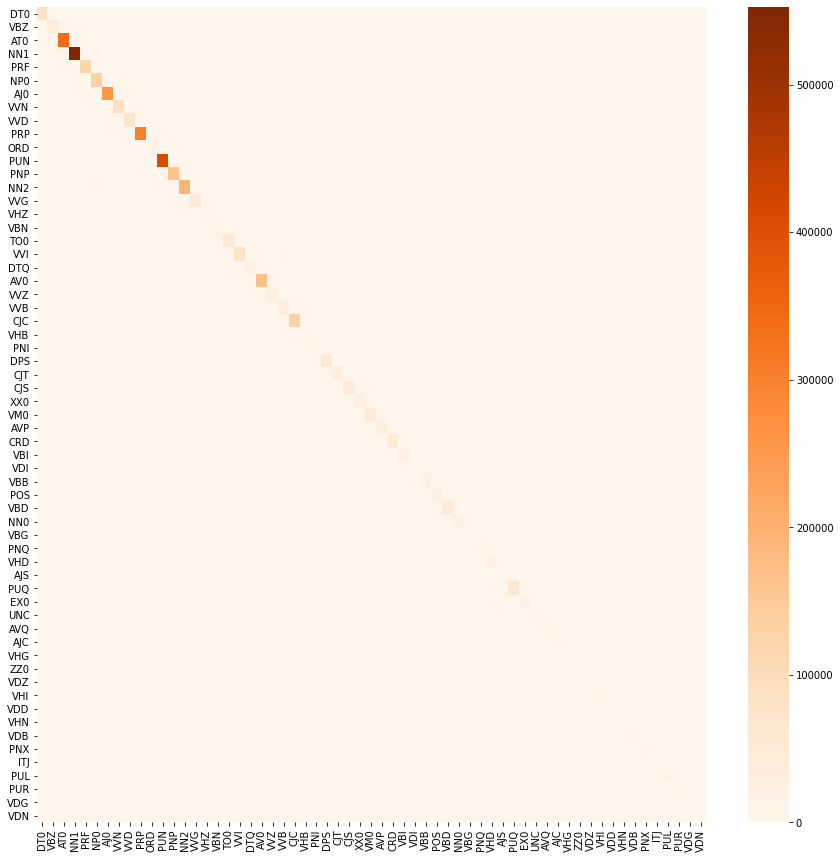

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
fig.set_facecolor('white')
mat=confusion_matrix(x,y,labels=tag_dict)
sum=mat.sum()
print(mat.shape)
sns.heatmap(mat,ax=ax,yticklabels=tag_dict,cmap='Oranges',xticklabels=tag_dict)

In [18]:
print("Accuracy is: ",np.trace(mat)/sum) #acc

Accuracy is:  0.9707899498830799


In [19]:
print("Processing Time : ",toc-tic," s")

Processing Time :  4709.878374  s
